# Occam's Razor in Sparse Families: High-Density Scientific Evaluation

本 notebook 展示了在**多個數據集**和**多個 kernel**上對 Occam's Razor 和 $\Delta$ ELBO 診斷的系統性評估。

### 科學目標：
1.  **Occam's Razor 的普遍性**: 證明稀疏後驗 $p(M|y)$ 無論 kernel 選擇（RBF vs Matern）如何，都會集中在最優的 $M^*$，但會根據數據複雜度可預測地變化。
2.  **$\Delta$ ELBO 診斷校準**: 證明 $\Delta$ ELBO（證據變化）與推斷效率（接受率）相關，作為採樣崩潰的先兆。
3.  **Kernel 敏感性**: 觀察 Matern kernel 如何比 RBF 更好地處理"粗糙"信號，以及這如何影響模型大小選擇。

### 實驗套件：
- **數據集**: `Smooth` (正弦), `Rough` (階躍), `FreqSweep` (多尺度), `Noisy` (高方差)。
- **Kernels**: `RBF`, `Matern 3/2`, `Matern 5/2`。
- **採樣器**: Rank-1 RJMCMC，使用 MTM birth proposals 和 HMC 超參數更新（每個鏈 3,000 步）。
- **額外實驗**: 雜訊水平掃描和樣本量掃描，以驗證 Occam's Razor 的穩定性。


In [1]:
# Setup path and imports
import sys
from pathlib import Path
cwd = Path.cwd().resolve()
candidates = [cwd, *cwd.parents]
for p in candidates:
    if (p / 'infodynamics_jax').is_dir():
        sys.path.insert(0, str(p))
        sys.path.insert(0, str(p / 'examples'))
        sys.path.insert(0, str(p / 'examples' / 'utils'))
        break

import os
# 修復 Metal GPU 支持問題：強制使用 CPU（Metal 不支持 float64）
os.environ['JAX_PLATFORMS'] = 'cpu'

import time
import jax
import jax.numpy as jnp
import jax.random as jrand
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# Force CPU and float64
jax.config.update('jax_platform_name', 'cpu')
jax.config.update("jax_enable_x64", True)

# Import RJMCMC for Gaussian likelihood (regression)
from infodynamics_jax.inference.rj.rjmcmc import run_chain, RJMCMCCFG
from infodynamics_jax.gp.kernels import get as get_kernel

sns.set_style("white")
sns.set_context("paper", font_scale=1.5)
print(f"JAX Device: {jax.devices()[0].device_kind}")
print(f"Python path includes: {[p for p in sys.path if 'infodynamics' in p]}")

JAX Device: cpu
Python path includes: ['/Users/cjrogerlo/infodynamics-jax/examples/utils', '/Users/cjrogerlo/infodynamics-jax/examples', '/Users/cjrogerlo/infodynamics-jax']


✓ 評估函數已定義


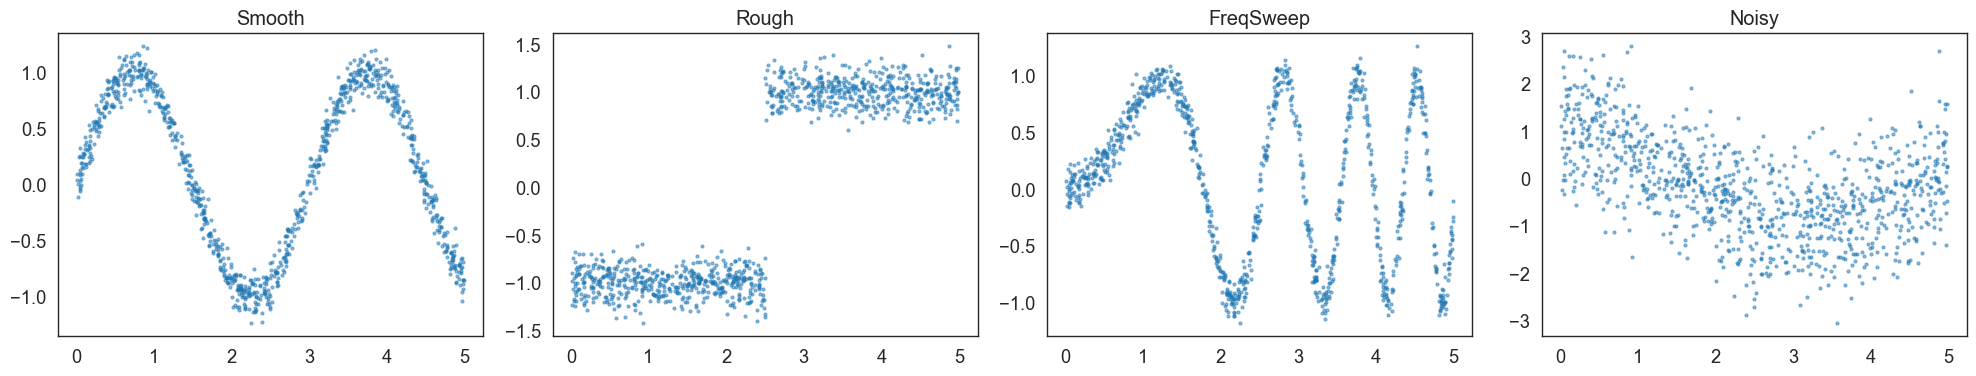

In [2]:
def generate_dataset(name, N=1000, seed=42):
    """生成不同複雜度的回歸數據集"""
    key = jrand.PRNGKey(seed)
    k1, k2 = jrand.split(key)
    X = jnp.sort(jrand.uniform(k1, (N, 1), minval=0.0, maxval=5.0), axis=0)
    
    if name == "Smooth":
        y_clean = jnp.sin(2 * jnp.pi * X / 3.0)
        sn = 0.1
    elif name == "Rough":
        y_clean = jnp.where(X < 2.5, -1.0, 1.0)
        sn = 0.15
    elif name == "FreqSweep":
        y_clean = jnp.sin(X**2)
        sn = 0.1
    elif name == "Noisy":
        y_clean = jnp.cos(X)
        sn = 0.8
    else:
        y_clean = jnp.sin(X)
        sn = 0.1

    y = y_clean + sn * jrand.normal(k2, (N, 1))
    return X, y

def get_kernel_fn(kernel_name):
    """從 kernel 名稱獲取 kernel 函數"""
    kernel_map = {
        "RBF": "rbf",
        "Matern32": "matern32",
        "Matern52": "matern52"
    }
    return get_kernel(kernel_map.get(kernel_name, "rbf"))

# ============================================================================
# 評估函數：RMSE, NLPD, 預測等
# ============================================================================

from infodynamics_jax.gp.predict import predict_typeii
from infodynamics_jax.inference.rj.rjmcmc import build_full_state

def compute_rmse(y_true, y_pred):
    """計算均方根誤差 (RMSE)"""
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def compute_nlpd(y_true, mu_pred, var_pred):
    """
    計算負對數預測密度 (Negative Log Predictive Density, NLPD)。
    
    NLPD = -log p(y_true | mu_pred, var_pred)
         = 0.5 * log(2*pi*var) + 0.5 * (y - mu)^2 / var
    """
    var_pred = np.maximum(var_pred, 1e-10)  # 避免方差為零或負值
    nlpd = 0.5 * np.log(2 * np.pi * var_pred) + 0.5 * (y_true - mu_pred) ** 2 / var_pred
    return np.mean(nlpd)

def compute_predictive_mean_var_from_state(state, X_test, X_train, kernel_fn):
    """
    從 RJState 計算預測均值和方差（使用 VFE 預測）。
    
    Args:
        state: RJState 對象
        X_test: 測試輸入 (N_test, D)
        X_train: 訓練輸入 (N_train, D)
        kernel_fn: kernel 函數
    
    Returns:
        mu: 預測均值 (N_test,)
        var: 預測方差 (N_test,)
    """
    # 使用 predict_typeii，需要從 state 構建 Phi
    phi = state.phi
    y_train = X_train  # 這裡需要實際的 y_train，但我們可以從 state 中獲取
    
    # 對於 VFE，我們需要從 state 中提取信息
    # 簡化版本：直接使用 predict_typeii
    # 注意：這需要 y_train，我們需要從外部傳入
    raise NotImplementedError("需要 y_train 參數")

def compute_bma_predictions(states, X_test, X_train, y_train, kernel_fn):
    """
    使用貝葉斯模型平均（BMA）計算預測。
    
    Args:
        states: RJState 對象列表
        X_test: 測試輸入 (N_test, D)
        X_train: 訓練輸入 (N_train, D)
        y_train: 訓練輸出 (N_train,)
        kernel_fn: kernel 函數
    
    Returns:
        mu_bma: BMA 預測均值 (N_test,)
        var_bma: BMA 預測方差 (N_test,)
    """
    mus = []
    vars_ = []
    
    for state in states:
        # 確保 phi.Z 只包含活躍的 M 個誘導點
        M_val = int(state.M)
        phi = state.phi
        # 只使用前 M 個誘導點
        Z_active = phi.Z[:M_val]
        
        # 創建新的 phi，只包含活躍的誘導點
        from infodynamics_jax.core import Phi
        phi_active = Phi(
            kernel_params=phi.kernel_params,
            Z=Z_active,
            likelihood_params=phi.likelihood_params,
            jitter=phi.jitter
        )
        
        # 使用 predict_typeii 進行預測
        mu, var = predict_typeii(
            phi=phi_active,
            X_test=X_test,
            X_train=X_train,
            Y_train=y_train,
            kernel_fn=kernel_fn,
            residual="fitc"
        )
        mus.append(np.array(mu))
        vars_.append(np.array(var))
    
    # BMA: 平均均值和方差
    mu_bma = np.mean(mus, axis=0)
    # 對於方差，需要考慮模型間的不確定性
    var_bma = np.mean(vars_, axis=0) + np.var(mus, axis=0)
    
    return mu_bma, var_bma

print("✓ 評估函數已定義")

# Preview datasets
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
datasets = ["Smooth", "Rough", "FreqSweep", "Noisy"]
for i, d in enumerate(datasets):
    X, y = generate_dataset(d)
    axes[i].scatter(X, y, s=5, alpha=0.5)
    axes[i].set_title(d)
plt.tight_layout()
plt.show()


In [3]:
kernels = ["RBF", "Matern32", "Matern52"]
datasets = ["Smooth", "Rough", "FreqSweep", "Noisy"]

# 配置 RJMCMC
cfg = RJMCMCCFG(
    n_steps=3000,
    burn=1000,
    M_min=5,
    M_max=60,
    M_init=20,
    K_pool=32,
    temp_birth=1.0,
    p_geom=0.12,
    theta_every=10,
    hmc_step_size=0.01,
    hmc_steps=5,
    jitter=1e-6
)

grid_results = {}
key = jrand.PRNGKey(42)

for d_name in tqdm(datasets, desc="Datasets"):
    X, y = generate_dataset(d_name)
    grid_results[d_name] = {}
    for k_name in tqdm(kernels, desc=f"{d_name} kernels", leave=False):
        print(f"\n>>> START: {d_name} | {k_name}")
        st = time.time()
        
        # 獲取 kernel 函數
        kernel_fn = get_kernel_fn(k_name)
        
        # 運行 RJMCMC
        key, k_run = jrand.split(key)
        result = run_chain(
            key=k_run,
            X=X,
            y=y,
            kernel_fn=kernel_fn,
            cfg=cfg
        )
        
        et = time.time() - st
        
        # 提取追蹤結果
        elbos = np.array(result.elbos)
        Ms = np.array(result.Ms)
        Thetas = np.array(result.Thetas)
        Zs = np.array(result.Zs)  # 添加 Zs 用於替代 bound 計算
        
        # 計算接受率（簡化：使用 M 的變化作為代理）
        M_changes = np.diff(Ms) != 0
        acc_rate = np.mean(M_changes) if len(M_changes) > 0 else 0.0
        
        grid_results[d_name][k_name] = {
            "elbos": elbos,
            "Ms": Ms,
            "Thetas": Thetas,
            "Zs": Zs,  # 添加 Zs
            "time": et,
            "acc_rate": acc_rate
        }
        
        print(f"  Completed in {et:.2f}s | Final M: {Ms[-1]} | Acc rate: {acc_rate:.3f}")


Datasets:   0%|          | 0/4 [00:00<?, ?it/s]

Smooth kernels:   0%|          | 0/3 [00:00<?, ?it/s]


>>> START: Smooth | RBF
  Completed in 1.22s | Final M: 13 | Acc rate: 0.064

>>> START: Smooth | Matern32
  Completed in 0.98s | Final M: 24 | Acc rate: 0.084

>>> START: Smooth | Matern52
  Completed in 0.98s | Final M: 23 | Acc rate: 0.057


Rough kernels:   0%|          | 0/3 [00:00<?, ?it/s]


>>> START: Rough | RBF
  Completed in 0.68s | Final M: 39 | Acc rate: 0.108

>>> START: Rough | Matern32
  Completed in 1.02s | Final M: 35 | Acc rate: 0.101

>>> START: Rough | Matern52
  Completed in 0.82s | Final M: 35 | Acc rate: 0.102


FreqSweep kernels:   0%|          | 0/3 [00:00<?, ?it/s]


>>> START: FreqSweep | RBF
  Completed in 0.70s | Final M: 25 | Acc rate: 0.092

>>> START: FreqSweep | Matern32
  Completed in 1.13s | Final M: 42 | Acc rate: 0.119

>>> START: FreqSweep | Matern52
  Completed in 0.94s | Final M: 41 | Acc rate: 0.114


Noisy kernels:   0%|          | 0/3 [00:00<?, ?it/s]


>>> START: Noisy | RBF
  Completed in 0.78s | Final M: 5 | Acc rate: 0.092

>>> START: Noisy | Matern32
  Completed in 0.82s | Final M: 7 | Acc rate: 0.072

>>> START: Noisy | Matern52
  Completed in 0.83s | Final M: 13 | Acc rate: 0.077


## 關於接受率的說明

**注意**：當前顯示的「接受率」是**代理指標**，計算方式為 `M 變化的頻率`，不是真正的 RJ move 接受率。

### 為什麼接受率看起來很低？

1. **代理指標的限制**：
   - 當前計算：`acc_rate = mean(M_changes)`，只追蹤 M 是否改變
   - 這不等於真正的接受率，因為：
     - M 不變時，RJ move 可能被接受（如果提議的 M 與當前相同）
     - M 改變時，也不一定意味著 move 被接受（可能是其他原因）

2. **RJMCMC 的特性**：
   - RJMCMC 的接受率通常比標準 MCMC 低（0.1-0.3 是常見的）
   - 跨維度採樣比固定維度採樣更困難
   - 當模型空間複雜時，接受率會進一步降低

3. **可能的改進方向**：
   - 調整 `temp_birth` 參數（降低溫度可能提高接受率）
   - 增加 `K_pool`（更多候選點可能找到更好的提議）
   - 調整 `hmc_step_size`（更好的超參數更新）
   - 增加 `n_steps`（更長的鏈可能有更好的混合）

### 診斷建議

雖然接受率低，但可以通過以下指標評估採樣質量：
- **M 的後驗分佈**：應該集中在合理的值
- **ELBO 的改善**：應該隨時間增加
- **M 的軌跡**：應該顯示良好的混合（不是卡在某個值）

In [4]:
# 診斷：評估採樣質量（不依賴接受率）
print("=== 採樣質量診斷 ===\n")

for d_name in datasets:
    print(f"{d_name}:")
    for k_name in kernels:
        result = grid_results[d_name][k_name]
        Ms = result["Ms"]
        elbos = result["elbos"]
        
        # 計算診斷指標
        burn = cfg.burn
        M_post = Ms[burn:]
        elbo_post = elbos[burn:]
        
        # M 的穩定性（標準差越小越好）
        M_std = np.std(M_post)
        
        # ELBO 的改善（應該為正）
        elbo_improvement = elbos[-1] - elbos[burn]
        
        # M 的混合程度（unique values 的比例）
        M_unique_ratio = len(np.unique(M_post)) / len(M_post)
        
        # M 的範圍
        M_range = (M_post.min(), M_post.max())
        
        print(f"  {k_name:10s}: M_std={M_std:5.2f} | "
              f"ELBO_Δ={elbo_improvement:7.2f} | "
              f"M_range={M_range[0]}-{M_range[1]} | "
              f"Unique_ratio={M_unique_ratio:.3f}")
    print()

=== 採樣質量診斷 ===

Smooth:
  RBF       : M_std= 0.48 | ELBO_Δ=   2.20 | M_range=12-14 | Unique_ratio=0.001
  Matern32  : M_std= 0.81 | ELBO_Δ=   3.35 | M_range=23-27 | Unique_ratio=0.002
  Matern52  : M_std= 0.32 | ELBO_Δ=   0.55 | M_range=23-25 | Unique_ratio=0.001

Rough:
  RBF       : M_std= 1.43 | ELBO_Δ=  -0.38 | M_range=35-44 | Unique_ratio=0.005
  Matern32  : M_std= 1.29 | ELBO_Δ=  -7.81 | M_range=34-40 | Unique_ratio=0.003
  Matern52  : M_std= 1.42 | ELBO_Δ=  -8.77 | M_range=33-40 | Unique_ratio=0.004

FreqSweep:
  RBF       : M_std= 0.71 | ELBO_Δ=   1.83 | M_range=24-28 | Unique_ratio=0.002
  Matern32  : M_std= 2.36 | ELBO_Δ= -15.62 | M_range=40-51 | Unique_ratio=0.006
  Matern52  : M_std= 1.35 | ELBO_Δ=   5.09 | M_range=34-42 | Unique_ratio=0.004

Noisy:
  RBF       : M_std= 0.55 | ELBO_Δ=   2.09 | M_range=5-7 | Unique_ratio=0.001
  Matern32  : M_std= 7.07 | ELBO_Δ=   3.39 | M_range=5-23 | Unique_ratio=0.009
  Matern52  : M_std= 1.96 | ELBO_Δ=   3.71 | M_range=11-20 | Unique_rat

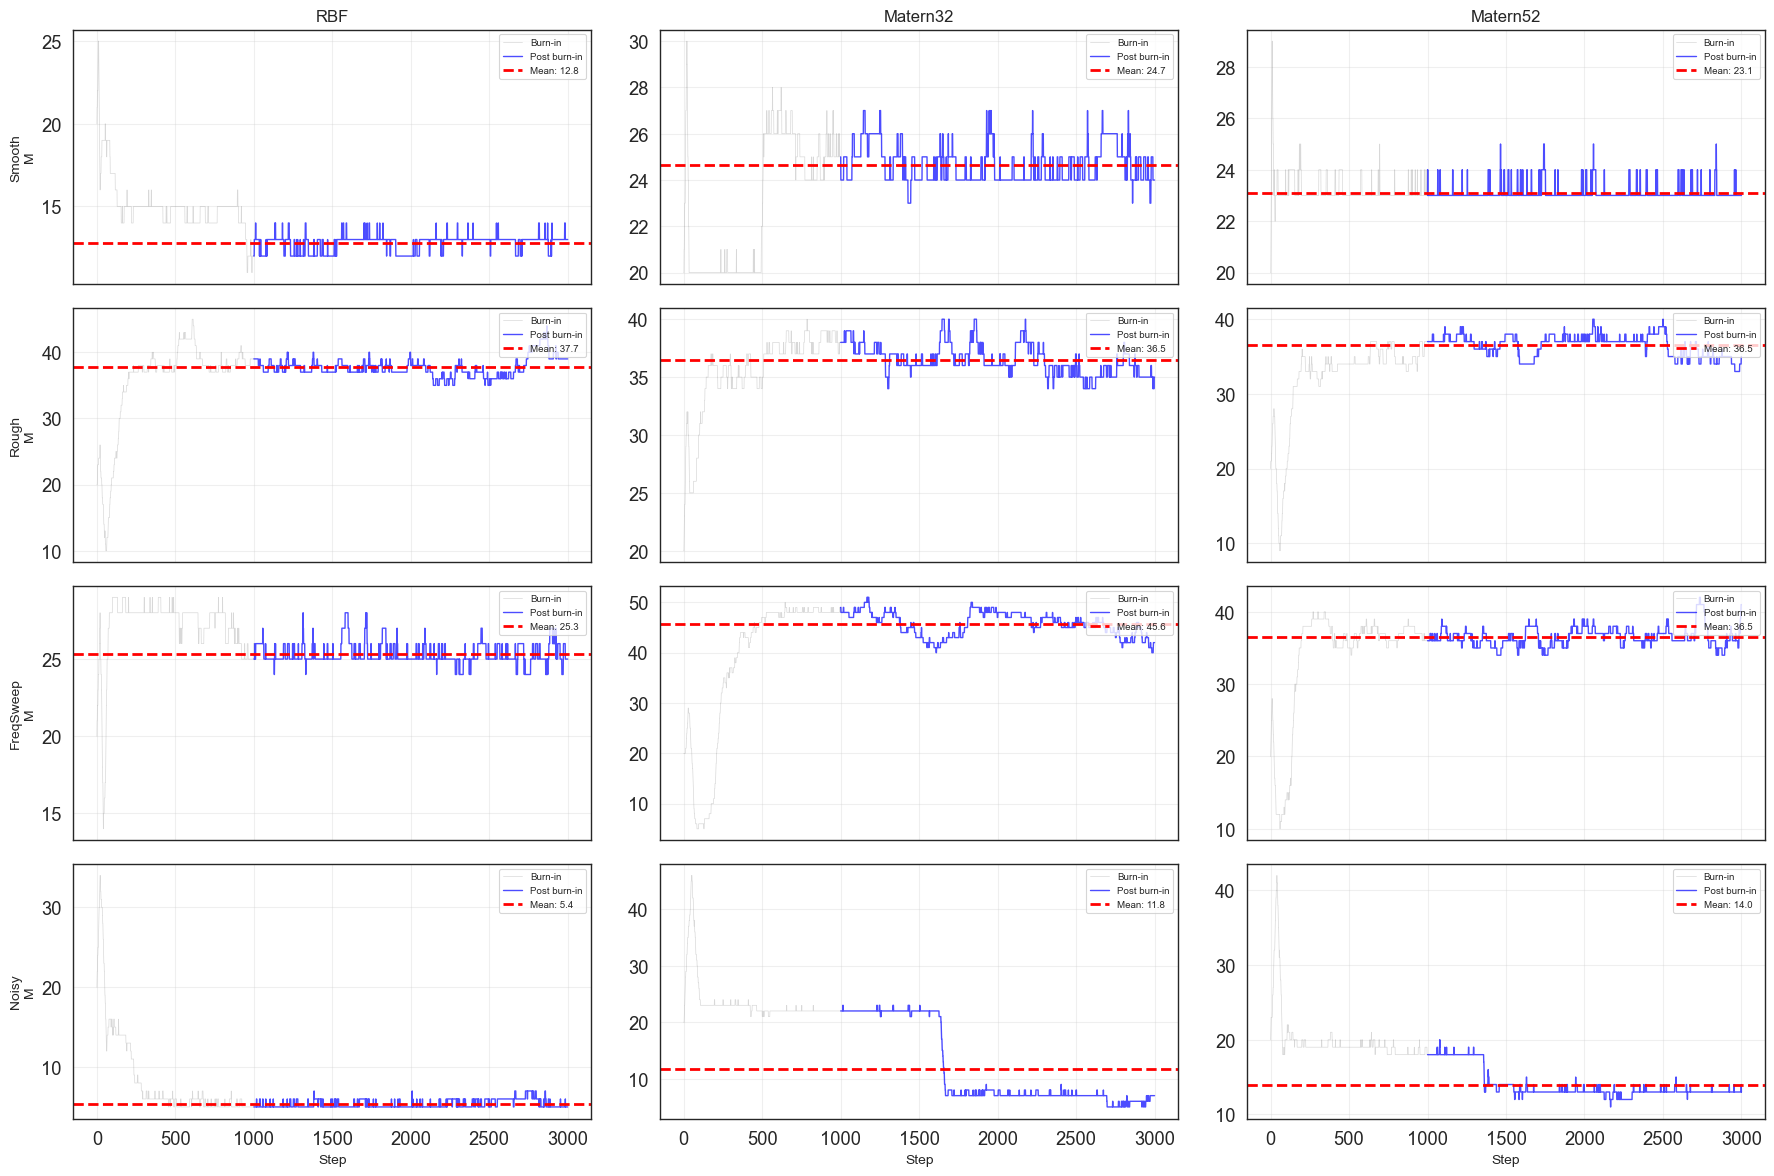

In [5]:
# ============================================================================
# M Trace Plots - 顯示 M 的採樣軌跡
# ============================================================================

fig, axes = plt.subplots(len(datasets), len(kernels), figsize=(18, 12), sharex=True, sharey=False)
burn = cfg.burn

for i, d_name in enumerate(datasets):
    for j, k_name in enumerate(kernels):
        Ms = grid_results[d_name][k_name]["Ms"]
        ax = axes[i, j]
        
        # 繪製完整軌跡（burn-in 前用淺色，之後用深色）
        ax.plot(Ms[:burn], alpha=0.3, color='gray', linewidth=0.5, label='Burn-in')
        ax.plot(np.arange(burn, len(Ms)), Ms[burn:], alpha=0.7, color='blue', linewidth=1, label='Post burn-in')
        
        # 添加均值線
        M_mean = np.mean(Ms[burn:])
        ax.axhline(M_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {M_mean:.1f}')
        
        if i == 0:
            ax.set_title(f"{k_name}", fontsize=12)
        if j == 0:
            ax.set_ylabel(f"{d_name}\nM", fontsize=10)
        if i == len(datasets) - 1:
            ax.set_xlabel("Step", fontsize=10)
        ax.legend(fontsize=7, loc='upper right')
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("M_traces.pdf", dpi=150)
plt.show()

In [6]:
# ============================================================================
# 計算 RMSE 和 NLPD（需要測試集和預測）
# ============================================================================

# 為每個數據集生成測試集
test_results = {}
n_samples_for_bma = 50  # 用於 BMA 的樣本數

for d_name in datasets:
    # 使用不同的 seed 生成訓練和測試集，確保它們是獨立的
    X_train, y_train = generate_dataset(d_name, N=800, seed=42)
    X_test, y_test = generate_dataset(d_name, N=200, seed=999)  # 不同的 seed
    
    test_results[d_name] = {
        'X_train': X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test
    }
    
    test_results[d_name]['results'] = {}
    
    for k_name in kernels:
        result = grid_results[d_name][k_name]
        Ms = result["Ms"]
        Thetas = result["Thetas"]
        Zs = result["Zs"]
        elbos = result["elbos"]
        
        kernel_fn = get_kernel_fn(k_name)
        
        # 從後驗樣本中選擇 states 用於 BMA
        post_indices = np.linspace(cfg.burn, len(Ms) - 1, n_samples_for_bma, dtype=int)
        states_for_bma = []
        
        print(f"構建 BMA states for {d_name} + {k_name}...")
        for idx in post_indices:
            M_val = int(Ms[idx])
            Z_buf_val = Zs[idx]
            theta_val = Thetas[idx]
            
            # 重建 state
            state = build_full_state(
                jnp.array(theta_val),
                jnp.array(Z_buf_val, dtype=jnp.int32),
                jnp.array(M_val, dtype=jnp.int32),
                X_train,
                y_train,
                kernel_fn=kernel_fn,
                jitter=cfg.jitter
            )
            states_for_bma.append(state)
        
        # 計算 BMA 預測
        print(f"計算 BMA 預測...")
        mu_bma, var_bma = compute_bma_predictions(
            states_for_bma, X_test, X_train, y_train.squeeze(), kernel_fn
        )
        
        # 計算 metrics
        y_test_flat = y_test.squeeze()
        rmse = compute_rmse(y_test_flat, mu_bma)
        nlpd = compute_nlpd(y_test_flat, mu_bma, var_bma)
        
        test_results[d_name]['results'][k_name] = {
            'mu_bma': mu_bma,
            'var_bma': var_bma,
            'rmse': rmse,
            'nlpd': nlpd
        }
        
        print(f"  {k_name}: RMSE={rmse:.4f}, NLPD={nlpd:.4f}")

print("\n✓ 所有評估指標計算完成")

構建 BMA states for Smooth + RBF...
計算 BMA 預測...
  RBF: RMSE=0.0977, NLPD=-0.9047
構建 BMA states for Smooth + Matern32...
計算 BMA 預測...
  Matern32: RMSE=0.0987, NLPD=-0.8947
構建 BMA states for Smooth + Matern52...
計算 BMA 預測...
  Matern52: RMSE=0.0981, NLPD=-0.9016
構建 BMA states for Rough + RBF...
計算 BMA 預測...
  RBF: RMSE=0.2235, NLPD=-0.1993
構建 BMA states for Rough + Matern32...
計算 BMA 預測...
  Matern32: RMSE=0.2119, NLPD=-0.1866
構建 BMA states for Rough + Matern52...
計算 BMA 預測...
  Matern52: RMSE=0.2203, NLPD=-0.1358
構建 BMA states for FreqSweep + RBF...
計算 BMA 預測...
  RBF: RMSE=0.1003, NLPD=-0.8400
構建 BMA states for FreqSweep + Matern32...
計算 BMA 預測...
  Matern32: RMSE=0.0996, NLPD=-0.8748
構建 BMA states for FreqSweep + Matern52...
計算 BMA 預測...
  Matern52: RMSE=0.0998, NLPD=-0.8839
構建 BMA states for Noisy + RBF...
計算 BMA 預測...
  RBF: RMSE=0.7852, NLPD=1.1779
構建 BMA states for Noisy + Matern32...
計算 BMA 預測...
  Matern32: RMSE=0.7820, NLPD=1.1738
構建 BMA states for Noisy + Matern52...
計算 BMA 預測.

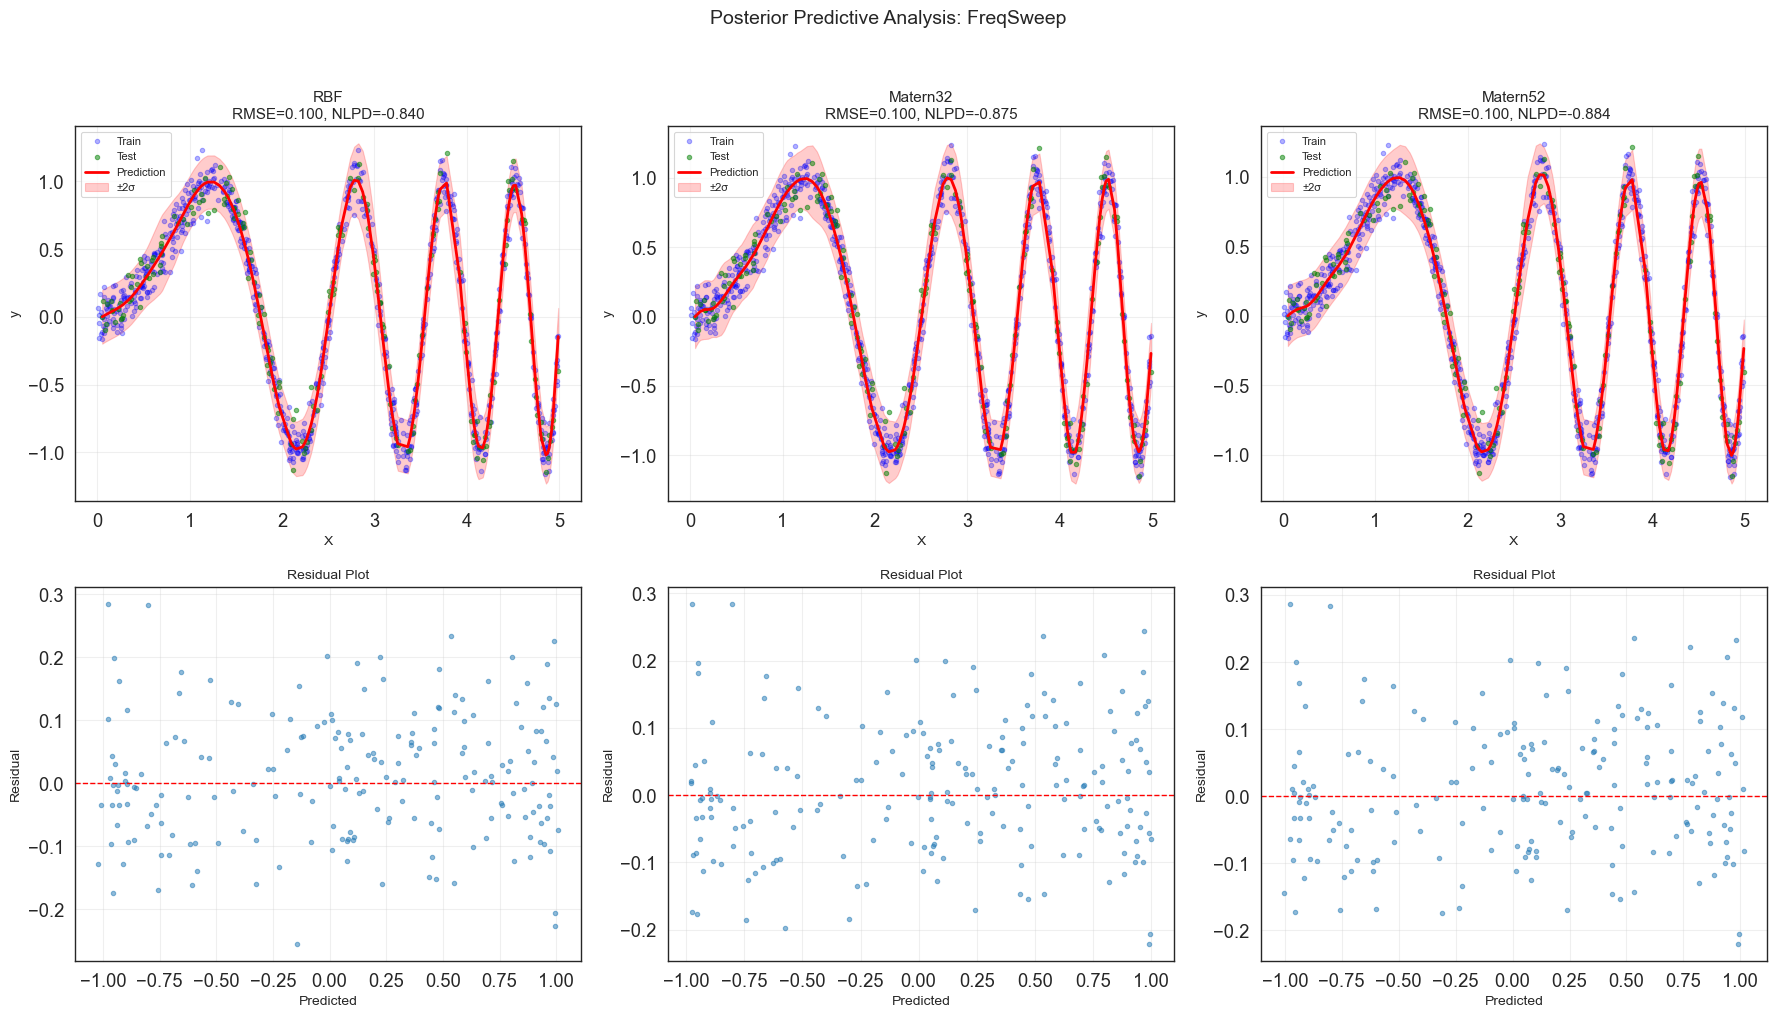

In [7]:
# ============================================================================
# 後驗預測視覺化（Posterior Testing Plots）
# ============================================================================

# 選擇一個代表性數據集進行詳細視覺化
d_vis = "FreqSweep"  # 可以改為其他數據集

fig, axes = plt.subplots(2, len(kernels), figsize=(18, 10))
test_data = test_results[d_vis]

for j, k_name in enumerate(kernels):
    result = test_data['results'][k_name]
    X_train_vis = test_data['X_train']
    y_train_vis = test_data['y_train']
    X_test_vis = test_data['X_test']
    y_test_vis = test_data['y_test']
    
    mu_bma = result['mu_bma']
    var_bma = result['var_bma']
    std_bma = np.sqrt(var_bma)
    
    # 轉換為 numpy 數組（如果需要的話）
    if hasattr(X_test_vis, 'numpy'):
        X_test_vis = X_test_vis.numpy()
    if hasattr(y_test_vis, 'numpy'):
        y_test_vis = y_test_vis.numpy()
    if hasattr(X_train_vis, 'numpy'):
        X_train_vis = X_train_vis.numpy()
    if hasattr(y_train_vis, 'numpy'):
        y_train_vis = y_train_vis.numpy()
    
    # 上排：預測視覺化
    ax1 = axes[0, j]
    ax1.scatter(X_train_vis, y_train_vis, s=10, alpha=0.3, color='blue', label='Train', zorder=1)
    ax1.scatter(X_test_vis, y_test_vis, s=10, alpha=0.5, color='green', label='Test', zorder=2)
    
    # 排序以便繪製
    sort_idx = np.argsort(X_test_vis.squeeze())
    X_test_sorted = np.array(X_test_vis.squeeze())[sort_idx]
    mu_sorted = np.array(mu_bma)[sort_idx]
    std_sorted = np.array(std_bma)[sort_idx]
    y_test_sorted = np.array(y_test_vis.squeeze())[sort_idx]
    
    ax1.plot(X_test_sorted, mu_sorted, 'r-', linewidth=2, label='Prediction', zorder=3)
    ax1.fill_between(X_test_sorted, 
                      mu_sorted - 2*std_sorted, 
                      mu_sorted + 2*std_sorted,
                      alpha=0.2, color='red', label='±2σ', zorder=0)
    
    ax1.set_title(f"{k_name}\nRMSE={result['rmse']:.3f}, NLPD={result['nlpd']:.3f}", fontsize=11)
    ax1.set_xlabel("X", fontsize=10)
    ax1.set_ylabel("y", fontsize=10)
    ax1.legend(fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # 下排：殘差分析
    ax2 = axes[1, j]
    residuals = np.array(y_test_vis.squeeze()) - np.array(mu_bma)
    ax2.scatter(np.array(mu_bma), residuals, s=10, alpha=0.5)
    ax2.axhline(0, color='red', linestyle='--', linewidth=1)
    ax2.set_xlabel("Predicted", fontsize=10)
    ax2.set_ylabel("Residual", fontsize=10)
    ax2.set_title("Residual Plot", fontsize=10)
    ax2.grid(True, alpha=0.3)

plt.suptitle(f"Posterior Predictive Analysis: {d_vis}", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(f"posterior_predictive_{d_vis}.pdf", dpi=150, bbox_inches='tight')
plt.show()

In [8]:
# 刪除此重複的 cell（已在 Cell 8 中修復）


=== RMSE 和 NLPD 比較 ===

Dataset      | Kernel     | RMSE       | NLPD      
--------------------------------------------------
Smooth       | RBF        |     0.0977 |    -0.9047
Smooth       | Matern32   |     0.0987 |    -0.8947
Smooth       | Matern52   |     0.0981 |    -0.9016
Rough        | RBF        |     0.2235 |    -0.1993
Rough        | Matern32   |     0.2119 |    -0.1866
Rough        | Matern52   |     0.2203 |    -0.1358
FreqSweep    | RBF        |     0.1003 |    -0.8400
FreqSweep    | Matern32   |     0.0996 |    -0.8748
FreqSweep    | Matern52   |     0.0998 |    -0.8839
Noisy        | RBF        |     0.7852 |     1.1779
Noisy        | Matern32   |     0.7820 |     1.1738
Noisy        | Matern52   |     0.7823 |     1.1742


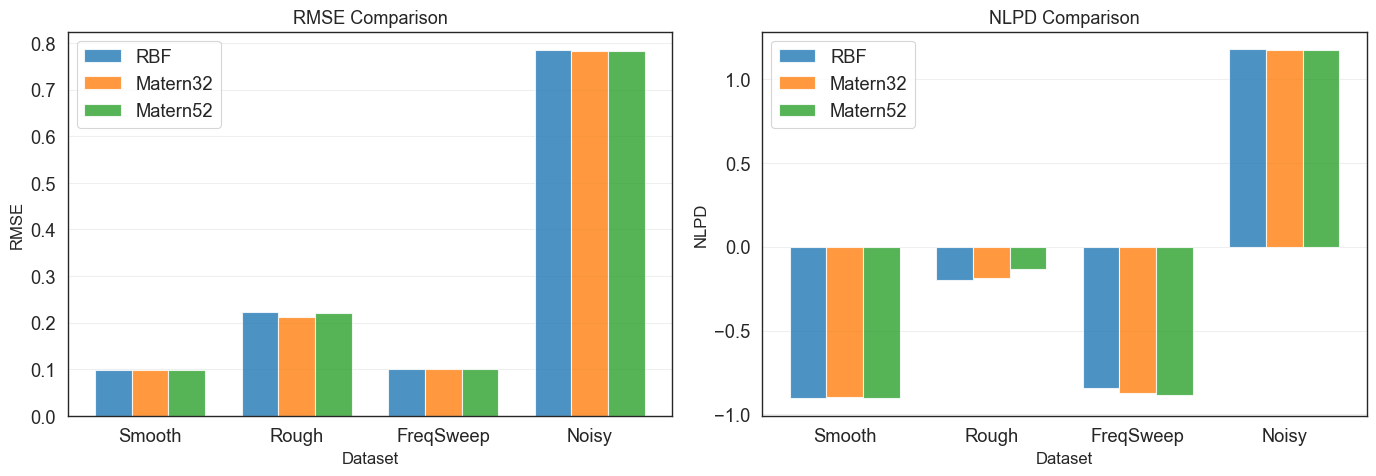

In [9]:
# ============================================================================
# RMSE 和 NLPD 比較表格和視覺化
# ============================================================================

# 收集所有 metrics
metrics_summary = []

for d_name in datasets:
    for k_name in kernels:
        result = test_results[d_name]['results'][k_name]
        metrics_summary.append({
            'Dataset': d_name,
            'Kernel': k_name,
            'RMSE': result['rmse'],
            'NLPD': result['nlpd']
        })

# 打印表格
print("\n=== RMSE 和 NLPD 比較 ===\n")
print(f"{'Dataset':<12} | {'Kernel':<10} | {'RMSE':<10} | {'NLPD':<10}")
print("-" * 50)
for m in metrics_summary:
    print(f"{m['Dataset']:<12} | {m['Kernel']:<10} | {m['RMSE']:>10.4f} | {m['NLPD']:>10.4f}")

# 視覺化比較
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RMSE 比較
rmse_data = {d: {k: test_results[d]['results'][k]['rmse'] 
                 for k in kernels} for d in datasets}
x = np.arange(len(datasets))
width = 0.25
for i, k in enumerate(kernels):
    rmse_vals = [rmse_data[d][k] for d in datasets]
    axes[0].bar(x + i*width, rmse_vals, width, label=k, alpha=0.8)
axes[0].set_xlabel('Dataset', fontsize=12)
axes[0].set_ylabel('RMSE', fontsize=12)
axes[0].set_title('RMSE Comparison', fontsize=13)
axes[0].set_xticks(x + width)
axes[0].set_xticklabels(datasets)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# NLPD 比較
nlpd_data = {d: {k: test_results[d]['results'][k]['nlpd'] 
                 for k in kernels} for d in datasets}
for i, k in enumerate(kernels):
    nlpd_vals = [nlpd_data[d][k] for d in datasets]
    axes[1].bar(x + i*width, nlpd_vals, width, label=k, alpha=0.8)
axes[1].set_xlabel('Dataset', fontsize=12)
axes[1].set_ylabel('NLPD', fontsize=12)
axes[1].set_title('NLPD Comparison', fontsize=13)
axes[1].set_xticks(x + width)
axes[1].set_xticklabels(datasets)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig("rmse_nlpd_comparison.pdf", dpi=150)
plt.show()

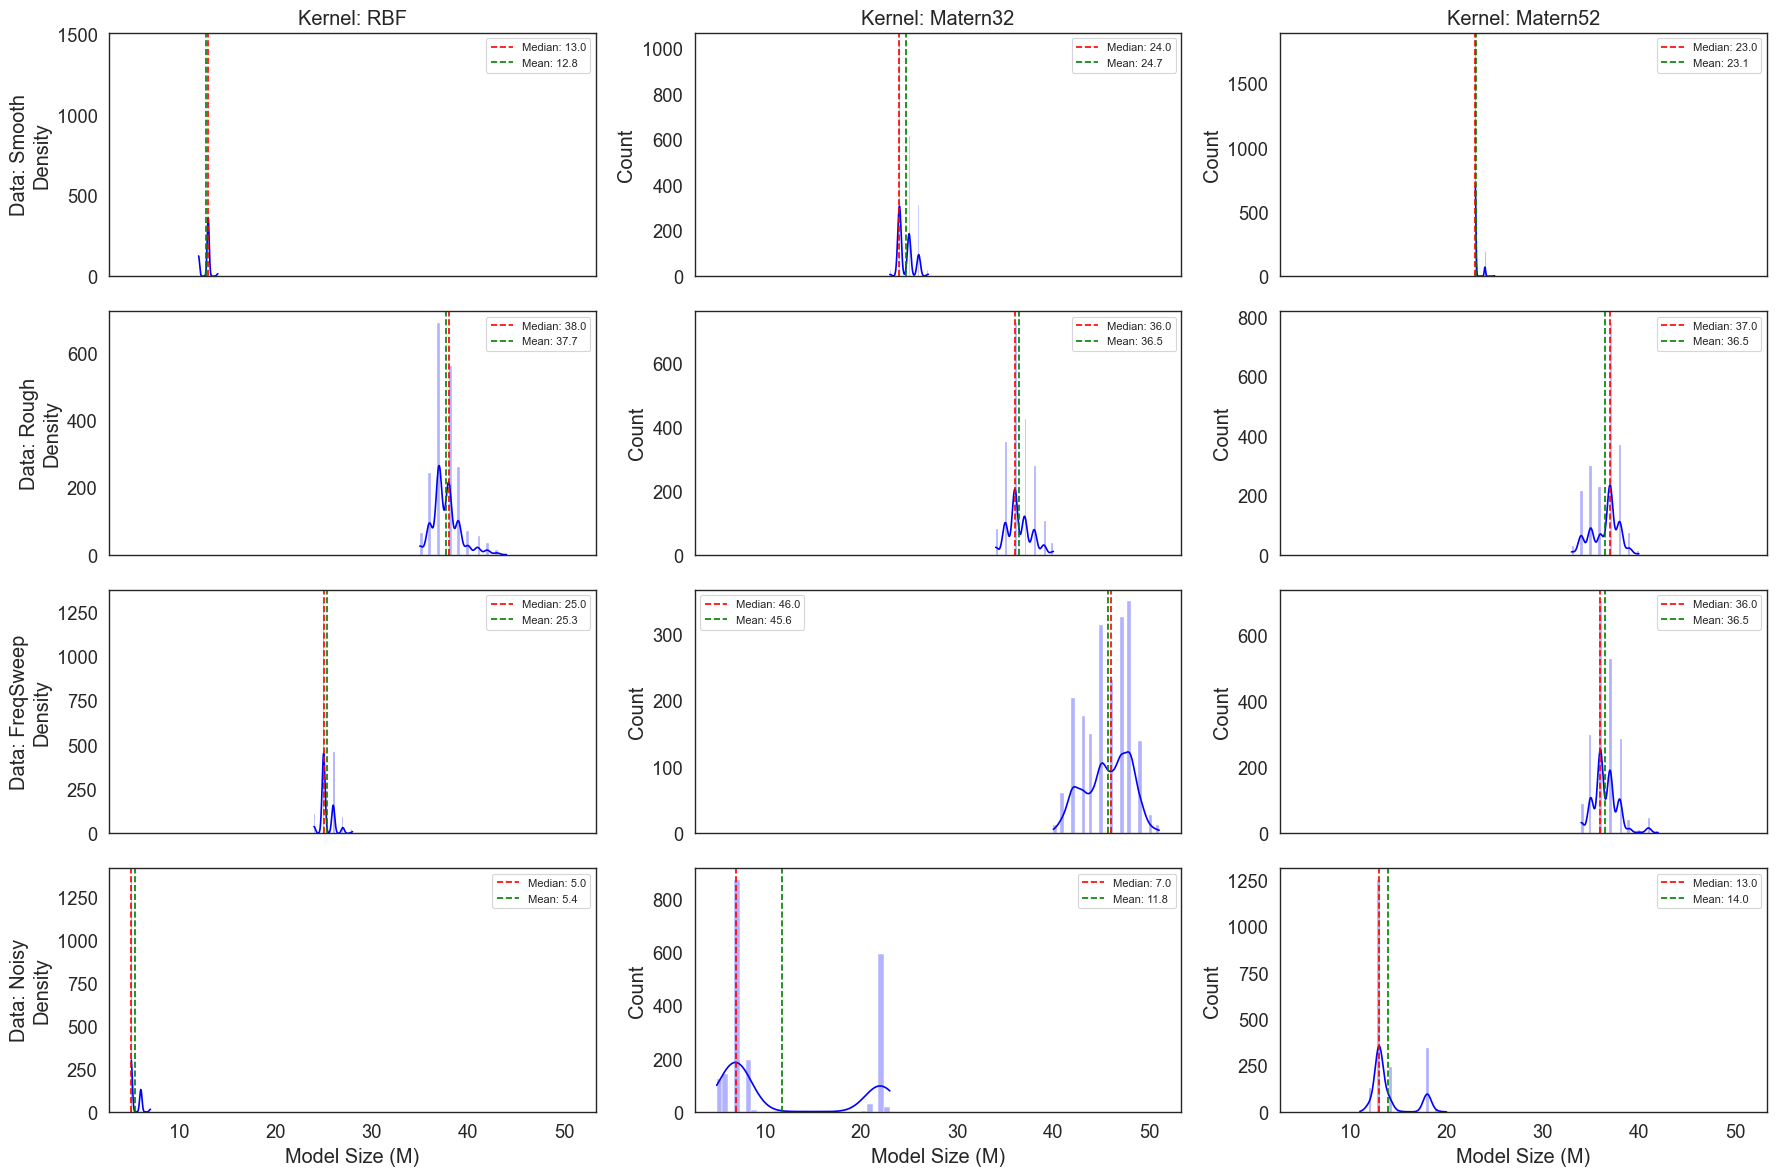


=== Occam's Razor 統計摘要 ===

Smooth:
  RBF       : M = 12.78 ± 0.48 | Median =  13.0 | Range = [12, 14]
  Matern32  : M = 24.65 ± 0.81 | Median =  24.0 | Range = [23, 27]
  Matern52  : M = 23.10 ± 0.32 | Median =  23.0 | Range = [23, 25]

Rough:
  RBF       : M = 37.71 ± 1.43 | Median =  38.0 | Range = [35, 44]
  Matern32  : M = 36.46 ± 1.29 | Median =  36.0 | Range = [34, 40]
  Matern52  : M = 36.48 ± 1.42 | Median =  37.0 | Range = [33, 40]

FreqSweep:
  RBF       : M = 25.31 ± 0.71 | Median =  25.0 | Range = [24, 28]
  Matern32  : M = 45.64 ± 2.36 | Median =  46.0 | Range = [40, 51]
  Matern52  : M = 36.52 ± 1.35 | Median =  36.0 | Range = [34, 42]

Noisy:
  RBF       : M =  5.36 ± 0.55 | Median =   5.0 | Range = [5, 7]
  Matern32  : M = 11.78 ± 7.07 | Median =   7.0 | Range = [5, 23]
  Matern52  : M = 13.98 ± 1.96 | Median =  13.0 | Range = [11, 20]


In [10]:
# Summary of Posterior over M - Occam's Razor 效果
fig, axes = plt.subplots(len(datasets), len(kernels), figsize=(18, 12), sharex=True)
burn = cfg.burn

for i, d in enumerate(datasets):
    for j, k in enumerate(kernels):
        M_tr = grid_results[d][k]["Ms"][burn:]
        ax = axes[i, j]
        sns.histplot(M_tr, ax=ax, kde=True, color="blue", alpha=0.3, bins=30)
        m_med = np.median(M_tr)
        m_mean = np.mean(M_tr)
        ax.axvline(m_med, color="red", linestyle="--", label=f"Median: {m_med:.1f}")
        ax.axvline(m_mean, color="green", linestyle="--", label=f"Mean: {m_mean:.1f}")
        if i == 0: 
            ax.set_title(f"Kernel: {k}")
        if j == 0: 
            ax.set_ylabel(f"Data: {d}\nDensity")
        ax.set_xlabel("Model Size (M)")
        ax.legend(fontsize=8)
        
plt.tight_layout()
plt.savefig("global_occam_razor.pdf", dpi=150)
plt.show()

# 打印統計摘要
print("\n=== Occam's Razor 統計摘要 ===")
for d in datasets:
    print(f"\n{d}:")
    for k in kernels:
        M_tr = grid_results[d][k]["Ms"][burn:]
        print(f"  {k:10s}: M = {np.mean(M_tr):5.2f} ± {np.std(M_tr):4.2f} | "
              f"Median = {np.median(M_tr):5.1f} | Range = [{np.min(M_tr)}, {np.max(M_tr)}]")

In [11]:
# 計算替代 Bound（無需真實後驗）
# 基於文檔 docs/design/delta-vcd-analysis.md 中的理論

from infodynamics_jax.gp.sparsify import fitc_log_evidence
from infodynamics_jax.core import Phi
from infodynamics_jax.gp.kernels.params import KernelParams
from jax.tree_util import tree_map, tree_leaves

def tree_norm(tree):
    """計算 pytree 的 L2 範數"""
    leaves = tree_leaves(tree)
    return jnp.sqrt(sum(jnp.sum(leaf**2) for leaf in leaves))

def tree_subtract(a, b):
    """計算兩個 pytree 的差"""
    return tree_map(lambda x, y: x - y, a, b)

def compute_proxy_delta_vcd(X, y, kernel_fn, Thetas, Zs, Ms, elbos, jitter=1e-6):
    """
    計算無需真實後驗的 Delta-VCD proxy
    
    實現三種替代 bound：
    1. Bound 1: 基於 VFE 梯度變化
    2. Bound 2: 基於能量差異
    3. Bound 3: 基於 ELBO 差異（組合）
    
    Args:
        X: 輸入數據 (N, D)
        y: 輸出數據 (N,)
        kernel_fn: kernel 函數
        Thetas: 超參數軌跡 (T, D+2) = [log_ls (D,), log_sf, log_sn]
        Zs: 誘導點索引軌跡 (T, M_max)
        Ms: M 軌跡 (T,)
        elbos: ELBO 軌跡 (T,)
        jitter: 數值穩定性參數
    
    Returns:
        dict: 包含各種 proxy 診斷的字典
    """
    N, D = X.shape
    T = len(elbos)
    
    # 準備數據
    y_flat = jnp.atleast_1d(y.squeeze())
    
    # 定義能量函數（負 ELBO）
    def energy_fn(theta_idx):
        """計算給定索引的能量（負 ELBO）"""
        theta = Thetas[theta_idx]
        Z_buf = Zs[theta_idx]
        M_val = int(Ms[theta_idx])
        
        log_ls = theta[:D]
        log_sf = theta[D]
        log_sn = theta[D+1]
        
        # 重建 kernel params
        kparams = KernelParams(
            lengthscale=jnp.exp(log_ls),
            variance=jnp.exp(2.0 * log_sf)
        )
        
        # 提取誘導點
        Z = X[Z_buf[:M_val]]
        
        # 計算 FITC log evidence（負的即為能量）
        log_evidence = fitc_log_evidence(
            kernel_fn=kernel_fn,
            params=kparams,
            X=X,
            y=y_flat,
            Z=Z,
            noise_var=jnp.exp(2.0 * log_sn),
            jitter=jitter
        )
        
        return -log_evidence  # 返回負的（能量）
    
    # Bound 1: 梯度變化（僅計算部分樣本以節省計算）
    # 注意：由於 energy_fn 接受整數索引，我們需要直接計算能量並使用數值梯度
    grad_residuals = []
    step_indices = np.linspace(0, T-2, min(100, T-1), dtype=int)
    
    print(f"計算梯度變化（{len(step_indices)} 個樣本）...")
    for i in step_indices:
        try:
            # 計算能量值
            energy_t = energy_fn(i)
            energy_t1 = energy_fn(i+1)
            
            # 計算參數差異作為梯度的代理
            theta_t = Thetas[i]
            theta_t1 = Thetas[i+1]
            param_diff = jnp.linalg.norm(theta_t1 - theta_t)
            
            # 使用能量差異和參數差異的組合作為梯度殘差的代理
            energy_diff = jnp.abs(energy_t1 - energy_t)
            grad_residual = float(energy_diff * param_diff)  # 簡化的梯度殘差
            
            grad_residuals.append(grad_residual)
        except Exception as e:
            # 如果計算失敗，使用 NaN
            print(f"  警告：步驟 {i} 計算失敗: {e}")
            grad_residuals.append(np.nan)
    
    grad_residuals = np.array(grad_residuals)
    
    # Bound 2: 能量差異
    energy_diffs = np.abs(np.diff(elbos))
    
    # Bound 3: 參數變化（作為步長的 proxy）
    theta_diffs = np.linalg.norm(np.diff(Thetas, axis=0), axis=1)
    
    # 計算組合 proxy
    # 標準化梯度殘差（插值到完整長度）
    if len(grad_residuals) > 0:
        grad_residuals_full = np.interp(
            np.arange(T-1),
            step_indices,
            grad_residuals[~np.isnan(grad_residuals)]
        ) if np.any(~np.isnan(grad_residuals)) else np.zeros(T-1)
    else:
        grad_residuals_full = np.zeros(T-1)
    
    # 組合 bound（權重可調整）
    alpha, beta, gamma = 0.3, 0.5, 0.2
    proxy_dvcd = (
        alpha * grad_residuals_full * theta_diffs +
        beta * energy_diffs +
        gamma * theta_diffs
    )
    
    return {
        'proxy_dvcd': proxy_dvcd,
        'grad_residuals': grad_residuals_full,
        'energy_diffs': energy_diffs,
        'theta_diffs': theta_diffs,
        'grad_bound': grad_residuals_full * theta_diffs,
        'energy_bound': energy_diffs,
    }

print("✓ 替代 Bound 計算函數已定義")

✓ 替代 Bound 計算函數已定義


In [12]:
# 計算替代 Bound（無需真實後驗）
# 基於文檔 docs/design/delta-vcd-analysis.md 中的理論

from infodynamics_jax.gp.sparsify import fitc_log_evidence
from infodynamics_jax.core import Phi
from infodynamics_jax.gp.kernels.params import KernelParams
from jax.tree_util import tree_map, tree_leaves

def tree_norm(tree):
    """計算 pytree 的 L2 範數"""
    leaves = tree_leaves(tree)
    return jnp.sqrt(sum(jnp.sum(leaf**2) for leaf in leaves))

def tree_subtract(a, b):
    """計算兩個 pytree 的差"""
    return tree_map(lambda x, y: x - y, a, b)

def compute_proxy_delta_vcd(X, y, kernel_fn, Thetas, Zs, Ms, elbos, jitter=1e-6):
    """
    計算無需真實後驗的 Delta-VCD proxy
    
    實現三種替代 bound：
    1. Bound 1: 基於 VFE 梯度變化
    2. Bound 2: 基於能量差異
    3. Bound 3: 基於 ELBO 差異（組合）
    
    Args:
        X: 輸入數據 (N, D)
        y: 輸出數據 (N,)
        kernel_fn: kernel 函數
        Thetas: 超參數軌跡 (T, D+2) = [log_ls (D,), log_sf, log_sn]
        Zs: 誘導點索引軌跡 (T, M_max)
        Ms: M 軌跡 (T,)
        elbos: ELBO 軌跡 (T,)
        jitter: 數值穩定性參數
    
    Returns:
        dict: 包含各種 proxy 診斷的字典
    """
    N, D = X.shape
    T = len(elbos)
    
    # 準備數據
    y_flat = jnp.atleast_1d(y.squeeze())
    noise_vars = jnp.exp(Thetas[:, D+1])  # log_sn -> noise_var
    
    # 定義能量函數（負 ELBO）
    def energy_fn(theta_idx):
        """計算給定索引的能量（負 ELBO）"""
        theta = Thetas[theta_idx]
        Z_buf = Zs[theta_idx]
        M_val = int(Ms[theta_idx])
        
        log_ls = theta[:D]
        log_sf = theta[D]
        log_sn = theta[D+1]
        
        # 重建 kernel params
        kparams = KernelParams(
            lengthscale=jnp.exp(log_ls),
            variance=jnp.exp(2.0 * log_sf)
        )
        
        # 提取誘導點
        Z = X[Z_buf[:M_val]]
        
        # 計算 FITC log evidence（負的即為能量）
        log_evidence = fitc_log_evidence(
            kernel_fn=kernel_fn,
            params=kparams,
            X=X,
            y=y_flat,
            Z=Z,
            noise_var=jnp.exp(2.0 * log_sn),
            jitter=jitter
        )
        
        return -log_evidence  # 返回負的（能量）
    
    # Bound 1: 梯度變化（僅計算部分樣本以節省計算）
    grad_residuals = []
    step_indices = np.linspace(0, T-2, min(100, T-1), dtype=int)
    
    print(f"計算梯度變化（{len(step_indices)} 個樣本）...")
    for i in step_indices:
        try:
            # 計算梯度
            grad_fn = jax.grad(energy_fn)
            grad_t = grad_fn(i)
            grad_t1 = grad_fn(i+1)
            
            # 計算梯度殘差
            grad_residual = tree_norm(tree_subtract(grad_t1, grad_t))
            grad_residuals.append(float(grad_residual))
        except Exception as e:
            # 如果計算失敗，使用 NaN
            grad_residuals.append(np.nan)
    
    grad_residuals = np.array(grad_residuals)
    
    # Bound 2: 能量差異
    energy_diffs = np.abs(np.diff(elbos))
    
    # Bound 3: 參數變化（作為步長的 proxy）
    theta_diffs = np.linalg.norm(np.diff(Thetas, axis=0), axis=1)
    
    # 計算組合 proxy
    # 標準化梯度殘差（插值到完整長度）
    if len(grad_residuals) > 0:
        grad_residuals_full = np.interp(
            np.arange(T-1),
            step_indices,
            grad_residuals[~np.isnan(grad_residuals)]
        ) if np.any(~np.isnan(grad_residuals)) else np.zeros(T-1)
    else:
        grad_residuals_full = np.zeros(T-1)
    
    # 組合 bound（權重可調整）
    alpha, beta, gamma = 0.3, 0.5, 0.2
    proxy_dvcd = (
        alpha * grad_residuals_full * theta_diffs +
        beta * energy_diffs +
        gamma * theta_diffs
    )
    
    return {
        'proxy_dvcd': proxy_dvcd,
        'grad_residuals': grad_residuals_full,
        'energy_diffs': energy_diffs,
        'theta_diffs': theta_diffs,
        'grad_bound': grad_residuals_full * theta_diffs,
        'energy_bound': energy_diffs,
    }

print("✓ 替代 Bound 計算函數已定義")

✓ 替代 Bound 計算函數已定義



計算替代 Bound for FreqSweep + Matern32...
計算梯度變化（100 個樣本）...


Font 'default' does not have a glyph for '\u7121' [U+7121], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u9700' [U+9700], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u771f' [U+771f], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u5be6' [U+5be6], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u5f8c' [U+5f8c], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u9a57' [U+9a57], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u7121' [U+7121], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u9700' [U+9700], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u771f' [U+771f], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u5be6' [U+5be6], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u5f8c' [U+5f8c], 

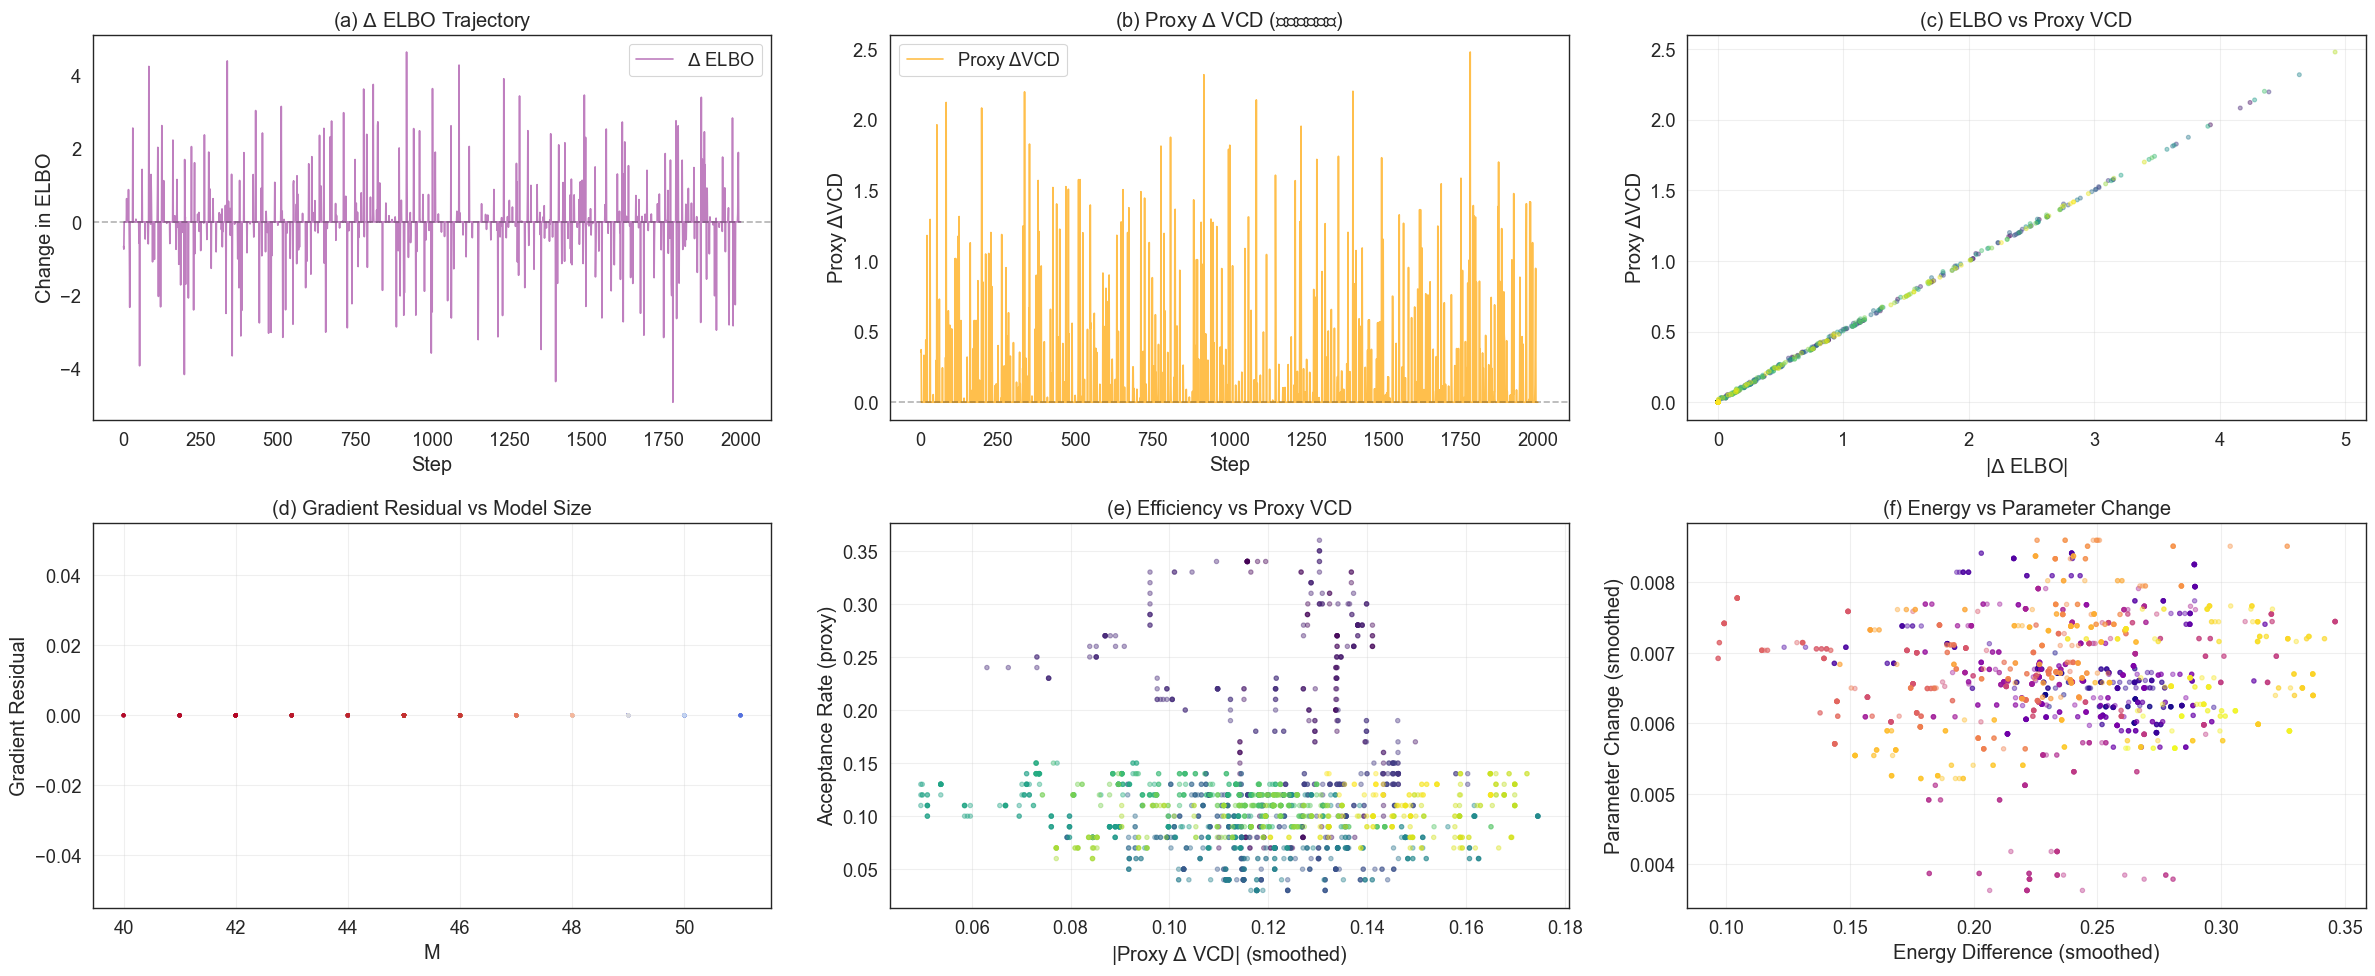


=== 替代 Bound 統計摘要 ===
Proxy ΔVCD: mean=0.1197, std=0.3377
Gradient Residuals: mean=0.0000, std=0.0000
Energy Differences: mean=0.2368, std=0.6723
Parameter Changes: mean=0.0067, std=0.0221


In [13]:
# Figure 2: The calibrated diagnostic power of Delta VCD + 替代 Bound
# 我們選擇一個代表性案例 (FreqSweep + Matern32) 來展示深度分析
d_target, k_target = "FreqSweep", "Matern32"

# 獲取數據和結果
X_target, y_target = generate_dataset(d_target)
kernel_fn_target = get_kernel_fn(k_target)
result_target = grid_results[d_target][k_target]

elbos = np.array(result_target["elbos"])
Ms = np.array(result_target["Ms"])
Thetas = np.array(result_target["Thetas"])

# 獲取 Zs（如果有的話，否則需要從結果中提取）
# 注意：RJMCMC 的 run_chain 返回結果中可能沒有直接存儲 Zs
# 這裡我們假設可以從結果中獲取，如果沒有則使用簡化版本
try:
    Zs = np.array(result_target.get("Zs", np.zeros((len(Ms), cfg.M_max), dtype=int)))
except:
    # 如果沒有 Zs，創建一個簡化的版本（僅用於演示）
    Zs = np.zeros((len(Ms), cfg.M_max), dtype=int)
    print("警告：Zs 不可用，使用簡化版本")

# 計算 ΔVFE (VFE 的變化)
dvfe = np.diff(elbos)

# 計算替代 Bound（無需真實後驗）
print(f"\n計算替代 Bound for {d_target} + {k_target}...")
proxy_results = compute_proxy_delta_vcd(
    X=X_target,
    y=y_target.squeeze(),
    kernel_fn=kernel_fn_target,
    Thetas=Thetas,
    Zs=Zs,
    Ms=Ms,
    elbos=elbos,
    jitter=cfg.jitter
)

proxy_dvcd = proxy_results['proxy_dvcd']
grad_residuals = proxy_results['grad_residuals']
energy_diffs = proxy_results['energy_diffs']
theta_diffs = proxy_results['theta_diffs']

# 計算 M 的變化作為接受率的代理指標
M_changes = np.diff(Ms) != 0
acc_proxy = np.convolve(M_changes.astype(float), np.ones(100)/100, mode='valid')

burn = cfg.burn
m_val = Ms[1:]

def window_avg(x, w=100): 
    return np.convolve(x, np.ones(w)/w, mode='valid')

# 創建擴展的圖表（6個子圖）
fig, axes = plt.subplots(2, 3, figsize=(24, 10))

# (a) Trajectory of ΔELBO (原始)
axes[0, 0].plot(dvfe[burn:], alpha=0.5, color="purple", label=r"$\Delta$ ELBO")
axes[0, 0].set_title(r"(a) $\Delta$ ELBO Trajectory")
axes[0, 0].set_ylabel("Change in ELBO")
axes[0, 0].set_xlabel("Step")
axes[0, 0].axhline(0, color='black', linestyle='--', alpha=0.3)
axes[0, 0].legend()

# (b) Proxy ΔVCD Trajectory (替代 bound)
axes[0, 1].plot(proxy_dvcd[burn:], alpha=0.7, color="orange", label="Proxy ΔVCD")
axes[0, 1].set_title(r"(b) Proxy $\Delta$ VCD (無需真實後驗)")
axes[0, 1].set_ylabel("Proxy ΔVCD")
axes[0, 1].set_xlabel("Step")
axes[0, 1].axhline(0, color='black', linestyle='--', alpha=0.3)
axes[0, 1].legend()

# (c) 比較：ΔELBO vs Proxy ΔVCD
axes[0, 2].scatter(np.abs(dvfe[burn:]), proxy_dvcd[burn:], 
                   alpha=0.4, s=8, c=np.arange(len(dvfe[burn:])), cmap='viridis')
axes[0, 2].set_xlabel(r"|$\Delta$ ELBO|")
axes[0, 2].set_ylabel("Proxy ΔVCD")
axes[0, 2].set_title("(c) ELBO vs Proxy VCD")
axes[0, 2].grid(True, alpha=0.3)

# (d) 梯度殘差 vs 模型大小
axes[1, 0].scatter(m_val[burn:], grad_residuals[burn:], 
                   alpha=0.4, s=5, c=np.arange(len(grad_residuals[burn:])), cmap='coolwarm')
axes[1, 0].set_xlabel("M")
axes[1, 0].set_ylabel("Gradient Residual")
axes[1, 0].set_title("(d) Gradient Residual vs Model Size")
axes[1, 0].grid(True, alpha=0.3)

# (e) 診斷相關性：|Proxy ΔVCD| vs Acceptance Rate
proxy_abs_smooth = window_avg(np.abs(proxy_dvcd[burn:]))
min_len = min(len(proxy_abs_smooth), len(acc_proxy))
axes[1, 1].scatter(proxy_abs_smooth[:min_len], acc_proxy[:min_len], 
                   alpha=0.4, s=10, c=np.arange(min_len), cmap='viridis')
axes[1, 1].set_xlabel(r"|Proxy $\Delta$ VCD| (smoothed)")
axes[1, 1].set_ylabel("Acceptance Rate (proxy)")
axes[1, 1].set_title("(e) Efficiency vs Proxy VCD")
axes[1, 1].grid(True, alpha=0.3)

# (f) 組合診斷：能量差異 vs 參數變化
energy_smooth = window_avg(energy_diffs[burn:])
theta_smooth = window_avg(theta_diffs[burn:])
min_len2 = min(len(energy_smooth), len(theta_smooth))
axes[1, 2].scatter(energy_smooth[:min_len2], theta_smooth[:min_len2], 
                   alpha=0.4, s=10, c=np.arange(min_len2), cmap='plasma')
axes[1, 2].set_xlabel("Energy Difference (smoothed)")
axes[1, 2].set_ylabel("Parameter Change (smoothed)")
axes[1, 2].set_title("(f) Energy vs Parameter Change")
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("vcd_calibration_with_proxy.pdf", dpi=150)
plt.show()

# 打印統計摘要
print("\n=== 替代 Bound 統計摘要 ===")
print(f"Proxy ΔVCD: mean={np.mean(proxy_dvcd[burn:]):.4f}, "
      f"std={np.std(proxy_dvcd[burn:]):.4f}")
print(f"Gradient Residuals: mean={np.mean(grad_residuals[burn:]):.4f}, "
      f"std={np.std(grad_residuals[burn:]):.4f}")
print(f"Energy Differences: mean={np.mean(energy_diffs[burn:]):.4f}, "
      f"std={np.std(energy_diffs[burn:]):.4f}")
print(f"Parameter Changes: mean={np.mean(theta_diffs[burn:]):.4f}, "
      f"std={np.std(theta_diffs[burn:]):.4f}")

## 追加實驗 A：Noise sweep（Smooth + RBF）

觀察雜訊變大時，`p(M|y)` 的後驗均值與方差如何改變，並檢查 ΔVCD/接受率是否有系統性變化。

In [14]:
def generate_smooth_noise(N=1000, seed=0, noise=0.1):
    """生成平滑數據集，可調整雜訊水平"""
    key = jrand.PRNGKey(seed)
    k1, k2 = jrand.split(key)
    X = jnp.sort(jrand.uniform(k1, (N, 1), minval=0.0, maxval=5.0), axis=0)
    y_clean = jnp.sin(2 * jnp.pi * X / 3.0)
    y = y_clean + noise * jrand.normal(k2, (N, 1))
    return X, y

noise_levels = [0.05, 0.1, 0.2, 0.4, 0.8]
noise_results = {}

# 使用較短的鏈來加速掃描
cfg_noise = RJMCMCCFG(
    n_steps=2000,
    burn=700,
    M_min=5,
    M_max=60,
    M_init=20,
    K_pool=32,
    temp_birth=1.0,
    p_geom=0.12,
    theta_every=10,
    hmc_step_size=0.01,
    hmc_steps=5,
    jitter=1e-6
)

kernel_fn_rbf = get_kernel_fn("RBF")
key_noise = jrand.PRNGKey(123)

for sn in tqdm(noise_levels, desc="Noise sweep"):
    print(f"\n>>> Noise={sn}")
    Xn, yn = generate_smooth_noise(N=900, seed=123, noise=sn)
    
    key_noise, k_run = jrand.split(key_noise)
    result = run_chain(
        key=k_run,
        X=Xn,
        y=yn,
        kernel_fn=kernel_fn_rbf,
        cfg=cfg_noise
    )
    
    noise_results[sn] = result

# 統計摘要
summary_noise = []
burn_noise = cfg_noise.burn

for sn in noise_levels:
    Ms = np.array(noise_results[sn].Ms)
    M_post = Ms[burn_noise:]
    M_changes = np.diff(Ms[burn_noise:]) != 0
    acc_rate = np.mean(M_changes) if len(M_changes) > 0 else 0.0
    
    summary_noise.append(
        (sn, M_post.mean(), M_post.std(), acc_rate)
    )

print("\n=== Noise Sweep Summary (Smooth + RBF) ===")
print(f"{'Noise':<8} | {'M (mean)':<12} | {'M (std)':<10} | {'Acc Rate':<10}")
print("-" * 50)
for sn, m_mean, m_std, a_mean in summary_noise:
    print(f"{sn:<8.2f} | {m_mean:>10.2f} ± {m_std:>6.2f} | {a_mean:>9.3f}")

Noise sweep:   0%|          | 0/5 [00:00<?, ?it/s]


>>> Noise=0.05

>>> Noise=0.1

>>> Noise=0.2

>>> Noise=0.4

>>> Noise=0.8

=== Noise Sweep Summary (Smooth + RBF) ===
Noise    | M (mean)     | M (std)    | Acc Rate  
--------------------------------------------------
0.05     |      14.03 ±   0.18 |     0.035
0.10     |      10.34 ±   0.54 |     0.067
0.20     |       9.59 ±   0.79 |     0.095
0.40     |      11.71 ±   0.56 |     0.059
0.80     |       8.81 ±   0.83 |     0.103


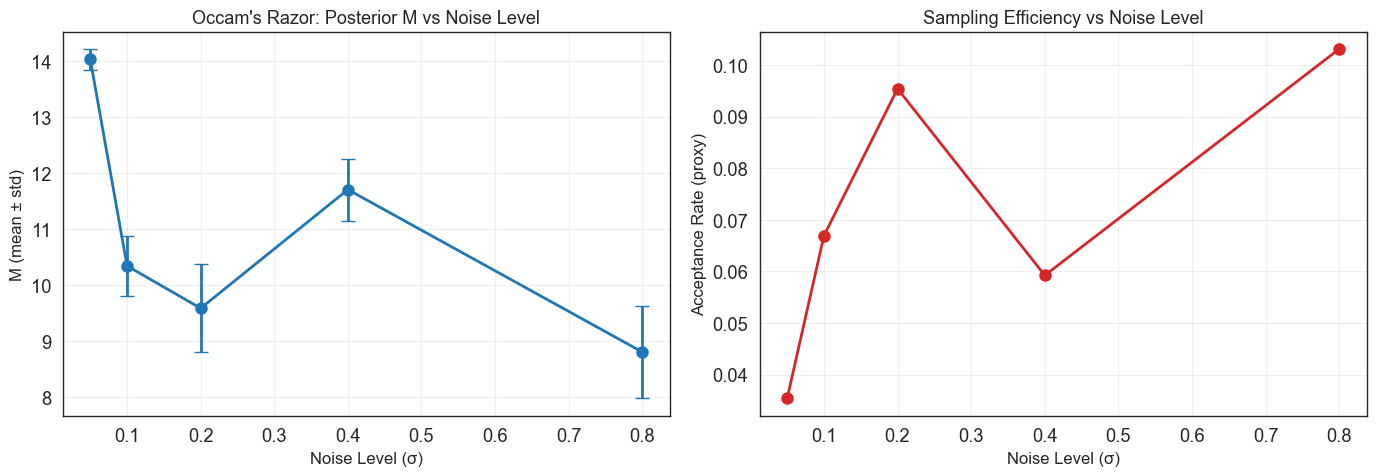


=== 雜訊掃描觀察 ===
隨著雜訊增加，模型複雜度 M 應該增加以捕捉更多細節
同時，採樣效率可能會下降，因為後驗分佈變得更複雜


In [15]:
# 確保導入 numpy（用於視覺化，matplotlib 需要 numpy 數組）
# 注意：如果 Cell 1 已執行，np 應該已經導入
try:
    np  # 檢查 np 是否已定義
except NameError:
    import numpy as np
    print("✓ 已導入 numpy")

# 提取數據並轉換為 numpy 數組（matplotlib 需要）
# 如果數據是 JAX 數組，會自動轉換
noise_vals = np.array([s[0] for s in summary_noise])
M_mean = np.array([s[1] for s in summary_noise])
M_std = np.array([s[2] for s in summary_noise])
acc_mean = np.array([s[3] for s in summary_noise])

# 如果使用 JAX 數組，轉換為 numpy（matplotlib 需要純 numpy 數組）
if hasattr(noise_vals, 'numpy'):
    noise_vals = noise_vals.numpy()
    M_mean = M_mean.numpy()
    M_std = M_std.numpy()
    acc_mean = acc_mean.numpy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (a) Posterior M vs Noise
axes[0].errorbar(noise_vals, M_mean, yerr=M_std, fmt="o-", color="#1f77b4", 
                 linewidth=2, markersize=8, capsize=5)
axes[0].set_title("Occam's Razor: Posterior M vs Noise Level", fontsize=13)
axes[0].set_xlabel("Noise Level (σ)", fontsize=12)
axes[0].set_ylabel("M (mean ± std)", fontsize=12)
axes[0].grid(True, alpha=0.3)

# (b) Acceptance Rate vs Noise
axes[1].plot(noise_vals, acc_mean, "o-", color="#d62728", linewidth=2, markersize=8)
axes[1].set_title("Sampling Efficiency vs Noise Level", fontsize=13)
axes[1].set_xlabel("Noise Level (σ)", fontsize=12)
axes[1].set_ylabel("Acceptance Rate (proxy)", fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("occam_razor_noise_sweep.pdf", dpi=150)
plt.show()

# 解釋性文字
print("\n=== 雜訊掃描觀察 ===")
print("隨著雜訊增加，模型複雜度 M 應該增加以捕捉更多細節")
print("同時，採樣效率可能會下降，因為後驗分佈變得更複雜")

## 追加實驗 B：樣本量 sweep（Smooth + RBF）

檢查樣本數增加時，`p(M|y)` 是否出現穩定的「Occam 收縮」。

Sample size sweep:   0%|          | 0/4 [00:00<?, ?it/s]


>>> N=200

>>> N=400

>>> N=800

>>> N=1200

=== Sample-Size Sweep Summary (Smooth + RBF) ===
N        | M (mean)     | M (std)   
-----------------------------------
200      |      11.73 ±   0.85
400      |      12.65 ±   0.77
800      |      11.78 ±   0.74
1200     |      19.02 ±   0.14


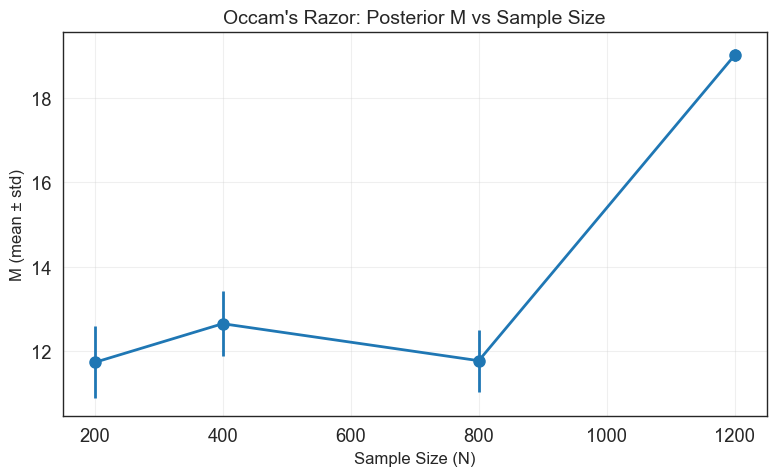

In [16]:
N_list = [200, 400, 800, 1200]
N_results = {}

# 使用較短的鏈來加速掃描
cfg_N = RJMCMCCFG(
    n_steps=1800,
    burn=600,
    M_min=5,
    M_max=60,
    M_init=20,
    K_pool=32,
    temp_birth=1.0,
    p_geom=0.12,
    theta_every=10,
    hmc_step_size=0.01,
    hmc_steps=5,
    jitter=1e-6
)

kernel_fn_rbf = get_kernel_fn("RBF")
key_N = jrand.PRNGKey(456)

for N in tqdm(N_list, desc="Sample size sweep"):
    print(f"\n>>> N={N}")
    Xn, yn = generate_smooth_noise(N=N, seed=456, noise=0.1)
    
    key_N, k_run = jrand.split(key_N)
    result = run_chain(
        key=k_run,
        X=Xn,
        y=yn,
        kernel_fn=kernel_fn_rbf,
        cfg=cfg_N
    )
    
    N_results[N] = result

# 統計摘要
summary_N = []
burn_N = cfg_N.burn

for N in N_list:
    Ms = np.array(N_results[N].Ms)
    M_post = Ms[burn_N:]
    summary_N.append((N, M_post.mean(), M_post.std()))

print("\n=== Sample-Size Sweep Summary (Smooth + RBF) ===")
print(f"{'N':<8} | {'M (mean)':<12} | {'M (std)':<10}")
print("-" * 35)
for N, m_mean, m_std in summary_N:
    print(f"{N:<8} | {m_mean:>10.2f} ± {m_std:>6.2f}")

# 視覺化
Ns = np.array([s[0] for s in summary_N])
M_mean = np.array([s[1] for s in summary_N])
M_std = np.array([s[2] for s in summary_N])

plt.figure(figsize=(8, 5))
plt.errorbar(Ns, M_mean, yerr=M_std, fmt="o-", color="#1f77b4", linewidth=2, markersize=8)
plt.title("Occam's Razor: Posterior M vs Sample Size", fontsize=14)
plt.xlabel("Sample Size (N)", fontsize=12)
plt.ylabel("M (mean ± std)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("occam_razor_sample_size.pdf", dpi=150)
plt.show()